# This notebook does preprocessing, and pre-analysing data before the annotation
The actions done in this notebook are 
- data merging
- data analysis and visualisation
- language identification
- sentiment analysis
- GDPR protection
- samples containing swear words detection

In [1]:
import json
import numpy as np
from transformers import pipeline
from tqdm import tqdm
import random
import re
import pickle

import matplotlib.pyplot as plt

/Users/A200119424/anaconda3/envs/sentiment/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# macros

OPTIMUM_WIDTH = 0.6
ALIGN = 'center'

# colors
BLUE = '#4040a1'
GREEN = '#618685'
YELLOW = '#feb236'
ORANGE = '#f18973'
AQUA = '#d5f4e6'
BLACK = '#000000'

In [3]:
def load_jsonl(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return [json.loads(line) for line in file]

In [4]:
def load_json(filename):
    with open(filename) as json_file:
        return json.load(json_file)

### Merge ficos data

In [6]:
merged_fico = []
for ficos_chunk in range(0,4):
    merged_fico += load_jsonl(f'clustered_jsonl/fico_chunk_{ficos_chunk}.jsonl')

In [7]:
def create_jsonl(filename, new_dataset):
    with open(f'{filename}l', 'w') as jsonl_file:
        for item in new_dataset:
            jsonl_file.write(json.dumps(item) + '\n')

In [8]:
create_jsonl('clustered_jsonl/robert_fico_data.json', merged_fico)

## Merge toppic data

In [5]:
def get_post_ids(posts):
    return [post['id'] for post in posts]

In [6]:
def open_data(fname: str):
    jsonl_data = load_jsonl(f'clustered_jsonl/{fname}l')
    json_data = load_json(f'json_data_id/{fname}')

    post_ids = get_post_ids(json_data)
    n_posts = len([post for post in jsonl_data if post['id'] in post_ids])

    dataset_info = {
        'name': " ".join(fname.split('_')[: -1]),
        'samples': len(jsonl_data),
        'n_posts': n_posts,
        'post_ids': post_ids
    }

    return jsonl_data, dataset_info

#### Politicians

In [7]:
fico_samples, fico_info = open_data("robert_fico_data.json")
matovic_samples, matovic_info = open_data("igor_matovic_data.json")
ekalinak_samples, ekalinak_info = open_data("erik_kaliňák_data.json")
caputova_samples, caputova_info = open_data("zuzana_čaputová_data.json")
kotleba_samples, kotleba_info = open_data("marian_kotleba_data.json")

#### Memes

In [8]:
zomri_samples, zomri_info = open_data("zomri_data.json")
emefka_samples, emefka_info = open_data("emefka_data.json")
ok_prv_samples, ok_prv_info = open_data("ok,ale_ideš_prvý_:d_data.json")

#### Media

In [9]:
eva_samples, eva_info = open_data("eva_-_hriešne_dobrá_data.json")
aktuality_samples, aktuality_info = open_data("aktuality_data.json")
dennikN_samples, dennikN_info = open_data("denník_n_data.json")
tvJOJ_samples, tvJOJ_info = open_data("televízia_joj_data.json")

#### Famous people

In [10]:
peter_marcin_samples, peter_marcin_info = open_data("peter_marcin_data.json")
sajfa_samples, sajfa_info = open_data("sajfa_data.json")
jan_kolenik_samples, jan_kolenik_info = open_data("ján_koleník_data.json")

#### Sports

In [11]:
sport24_samples, sport24_info = open_data("šport24_data.json")
dominika_cibulkova_samples, dominika_cibulkova_info= open_data("dominika_cibulkova_data.json")
hetrik_samples, hetrik_info = open_data("hetrik_data.json")
RTVSsport_samples, RTVSsport_info = open_data("šport_v_rtvs_data.json")
sagan_samples, sagan_info = open_data("peter_sagan_data.json")

# Data analysis & visualisation

In [15]:
def show_scraped_data(toppic: str, samples: list, names: list, posts: list):
    fig, ax = plt.subplots(
        nrows = 1,
        ncols = 2,
        figsize = (17, 5)
    )

    fig.suptitle(f'Number of extracted records on toppic: {toppic}', fontsize=20)

    # first barh chart
    
    for axis in ax:
        axis.set_ylabel('Facebook profiles')
        axis.set_xlabel('Number of samples')
        
    ax[0].title.set_text("All samples")
    ax[0].set_xlim(0, max(samples) * 1.2)

    for idx, val in enumerate(samples):
        ax[0].text(val, idx, str(val), color='black', va='center')


    ax[0].barh(
        y = names,
        width = samples,
        edgecolor = BLACK,
        color = [BLUE, GREEN, AQUA, ORANGE, YELLOW]
    )

    # second barh chart
    
    ax[1].title.set_text("Posts")
    ax[1].set_xlim(0, max(posts) * 1.2)

    ax[1].barh(
        y = names,
        width = posts,
        edgecolor = BLACK,
        color = [BLUE, GREEN, AQUA, ORANGE, YELLOW]
    )

    for idx, val in enumerate(posts):
        ax[1].text(val, idx, str(val), color='black', va='center')

    plt.subplots_adjust(wspace=0.5)
    plt.show()

In [16]:
def execute_visualisation(toppic: str, info_list: list):

    if toppic == None:
        each_sample = np.empty(0, dtype=np.int32)
        each_post = np.empty(0, dtype=np.int32)
        names = np.array([
                'Politicians',
                'Memes',
                'Media',
                'Famous people',
                'Sports'
            ]
        )

        for toppic in info_list:
            each_sample = np.append(each_sample, sum([profile['samples'] for profile in toppic]))
            each_post = np.append(each_post, sum([profile['n_posts'] for profile in toppic]))

        show_scraped_data('By toppic', each_sample, names, each_post)
    else:
        each_sample = np.array(
            [item['samples'] for item in info_list]
        )

        names = np.array(
            [item['name'] for item in info_list]
        )

        each_post = np.array(
            [item['n_posts'] for item in info_list]
        )

        show_scraped_data(toppic, each_sample, names, each_post)


# Scraped data visualisation
Those graphs represent how many samples we were able to extract from Facebook, those data are cleaned and clustered based on their semantical similarity.

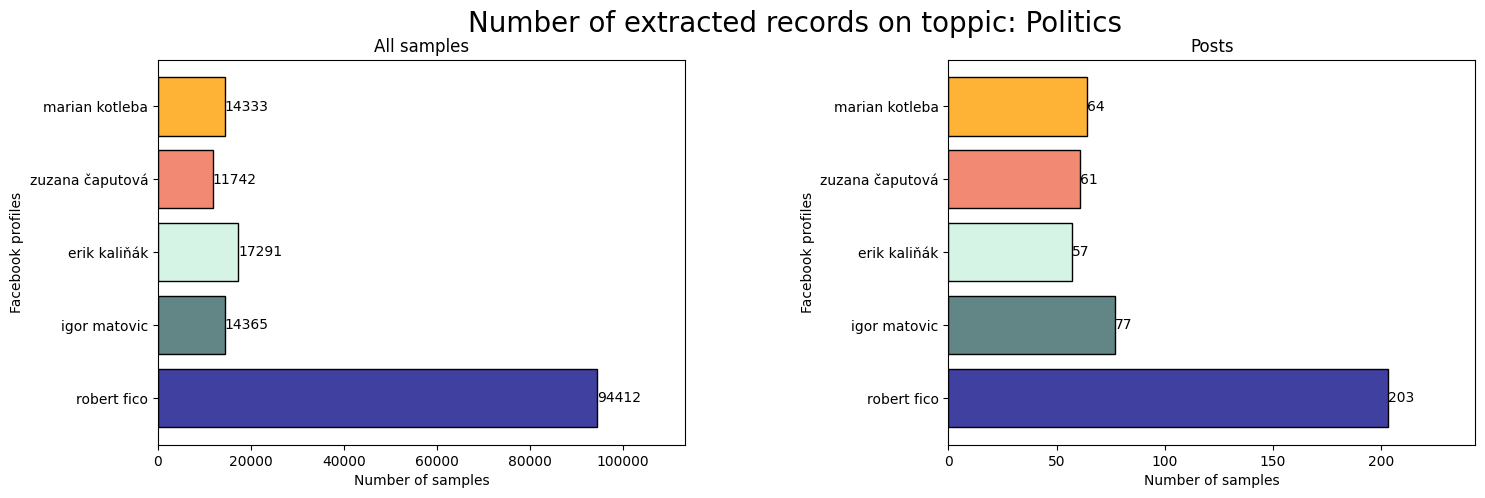

In [17]:
# Politics
politics_info_list = [fico_info, matovic_info, ekalinak_info, caputova_info, kotleba_info]
execute_visualisation('Politics', politics_info_list)

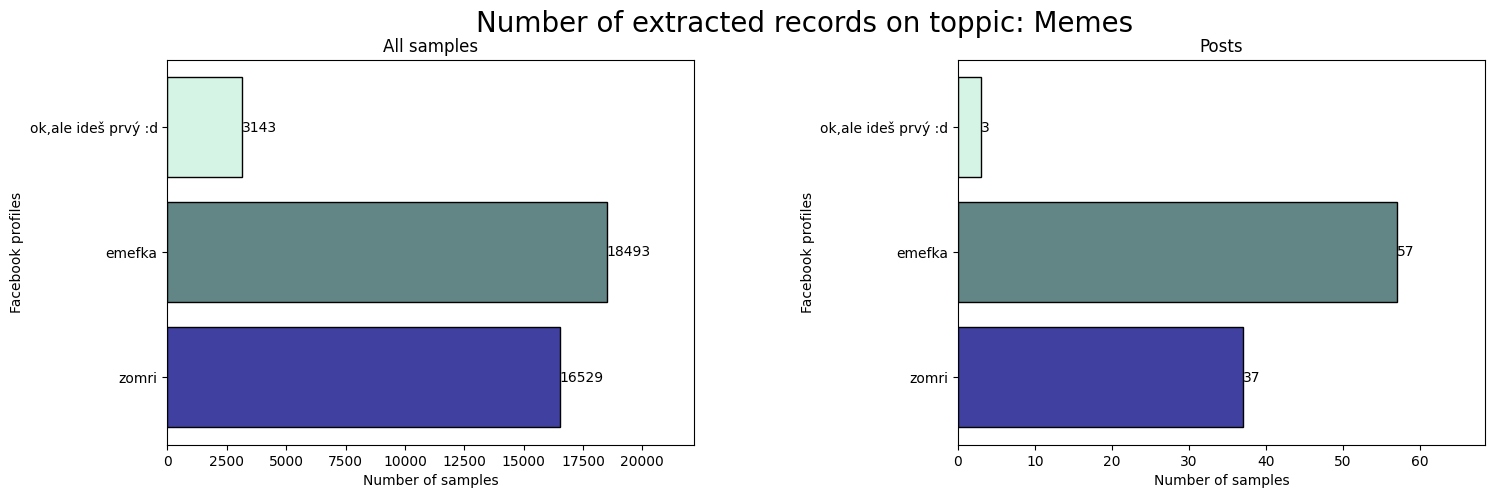

In [18]:
# Memes
memes_info_list = [zomri_info, emefka_info, ok_prv_info]
execute_visualisation('Memes', memes_info_list)

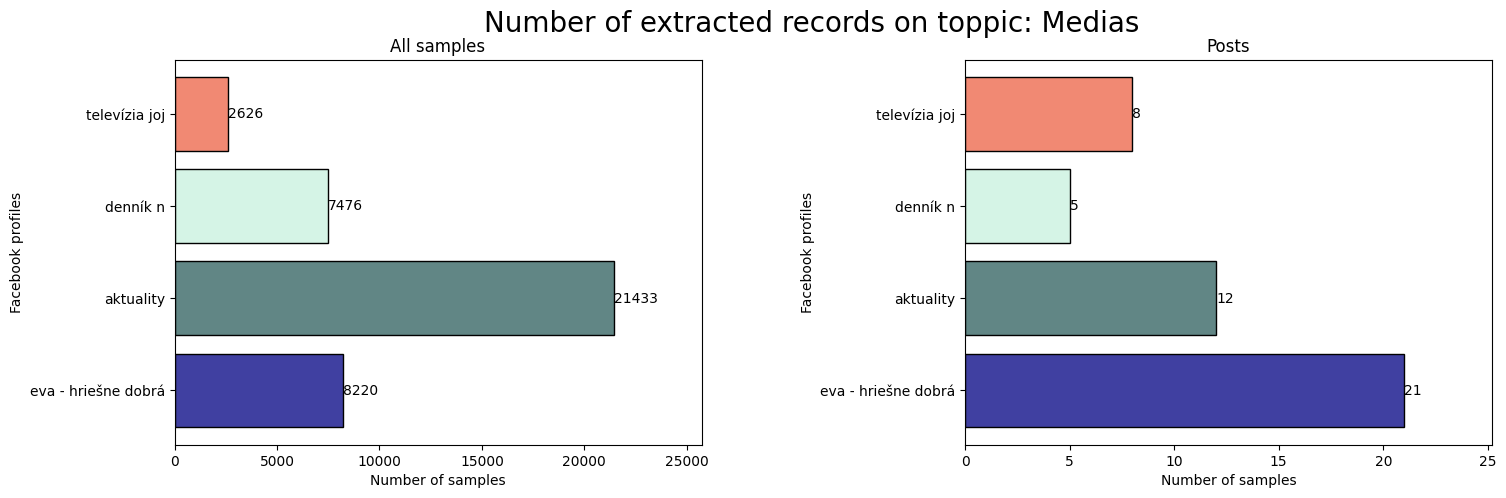

In [19]:
# Media
media_info_list = [eva_info, aktuality_info, dennikN_info, tvJOJ_info]
execute_visualisation('Medias', media_info_list)

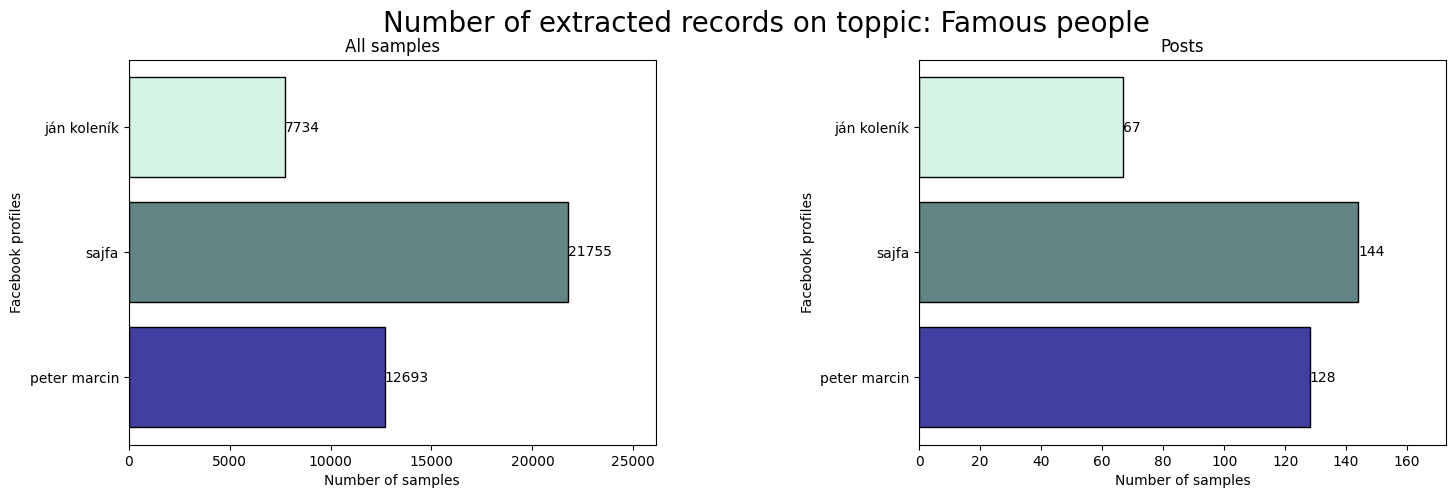

In [20]:
# Famous people
fame_info_list = [peter_marcin_info, sajfa_info, jan_kolenik_info]
execute_visualisation('Famous people', fame_info_list)

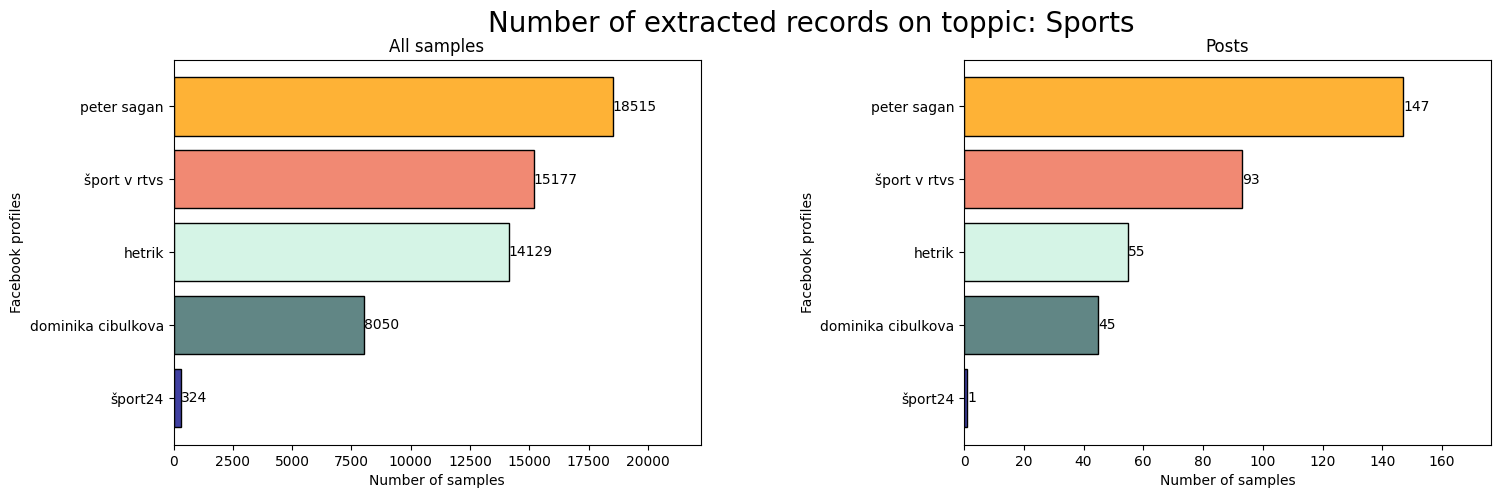

In [21]:
# Sports
sport_info_list = [sport24_info, dominika_cibulkova_info, hetrik_info, RTVSsport_info, sagan_info]
execute_visualisation('Sports', sport_info_list)

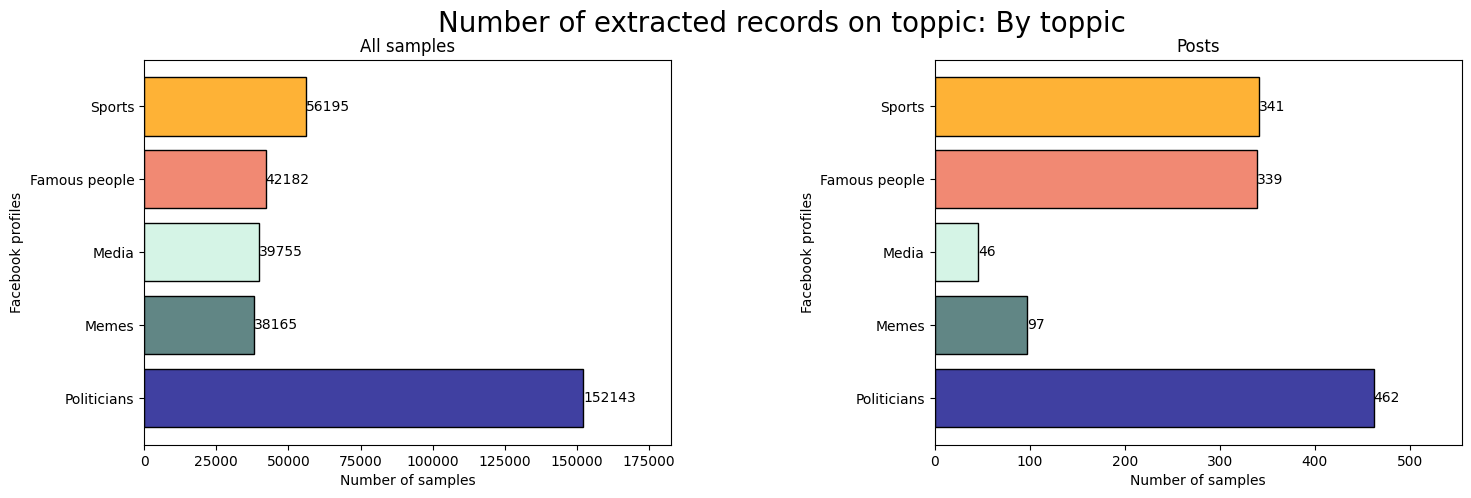

In [22]:
# By toppic
execute_visualisation(None, [politics_info_list, memes_info_list, media_info_list, fame_info_list, sport_info_list])

# Language identification

In [23]:
lang_identification_pipeline = pipeline("text-classification", model="papluca/xlm-roberta-base-language-detection")

In [31]:
cibulkova_idxs = np.empty(0, dtype=np.int32)

for idx, text in enumerate(tqdm(dominika_cibulkova_samples)):
    try:
        identified_text = lang_identification_pipeline(text['text'])[0]
        if identified_text['label'] in ['en', 'es'] and identified_text['score'] > 0.70:
            cibulkova_idxs = np.append(cibulkova_idxs, idx)
    except Exception as err:
        print(err)

  4%|▍         | 333/8050 [00:17<05:52, 21.91it/s]

The expanded size of the tensor (535) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 535].  Tensor sizes: [1, 514]


 26%|██▌       | 2113/8050 [01:53<04:38, 21.31it/s]

The expanded size of the tensor (524) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 524].  Tensor sizes: [1, 514]


 77%|███████▋  | 6215/8050 [05:33<01:25, 21.49it/s]

The expanded size of the tensor (554) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 554].  Tensor sizes: [1, 514]


100%|██████████| 8050/8050 [07:14<00:00, 18.53it/s]


In [41]:
sagan_idxs = np.empty(0, dtype=np.int32)

for idx, text in enumerate(tqdm(sagan_samples)):
    try:
        identified_text = lang_identification_pipeline(text['text'])[0]
        if identified_text['label'] in ['en', 'es'] and identified_text['score'] > 0.70:
            sagan_idxs = np.append(sagan_idxs, idx)
    except Exception as err:
        print(err)

 33%|███▎      | 6049/18515 [05:07<09:39, 21.51it/s]

The expanded size of the tensor (1268) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1268].  Tensor sizes: [1, 514]


 51%|█████     | 9469/18515 [07:58<06:49, 22.10it/s]

The expanded size of the tensor (1764) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1764].  Tensor sizes: [1, 514]


 66%|██████▌   | 12208/18515 [10:15<05:12, 20.16it/s]

The expanded size of the tensor (1036) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1036].  Tensor sizes: [1, 514]


 71%|███████   | 13139/18515 [11:02<04:08, 21.62it/s]

The expanded size of the tensor (959) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 959].  Tensor sizes: [1, 514]


 72%|███████▏  | 13298/18515 [11:10<03:59, 21.81it/s]

The expanded size of the tensor (893) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 893].  Tensor sizes: [1, 514]


100%|██████████| 18515/18515 [15:34<00:00, 19.81it/s]


### Dropping english and spannish data from famous slovak sportsmen

In [44]:
cibulkova_idxs_reversed = cibulkova_idxs[::-1]
for idx in cibulkova_idxs_reversed:
    dominika_cibulkova_samples.pop(idx)

In [46]:
sagan_idxs_reversed = sagan_idxs[::-1]
for idx in sagan_idxs_reversed:
    sagan_samples.pop(idx)

In [48]:
with open('clustered_jsonl/dominika_slovak.jsonl', 'w') as f:
    for item in dominika_cibulkova_samples:
        json.dump(item, f)
        f.write('\n')

### Get number of posts in the data

In [13]:
def get_num_of_posts(data: list, info: dict):
    return len([item for item in data if item['id'] in info['post_ids']])

# Data merging

### Meme data merging

In [14]:
meme_samples_final = []

meme_samples_final += zomri_samples
meme_samples_final += emefka_samples

# ok ale ides prvy dont consist any type of criticism or hate
post_meme = get_num_of_posts(zomri_samples, zomri_info) + get_num_of_posts(emefka_samples, emefka_info)
meme_share = len(meme_samples_final)

### Media data merging

In [15]:
media_samples_final = []

eva_hate = eva_samples[250: 387]

eva_hate_1 = eva_samples[700:]

media_samples_final += eva_hate
media_samples_final += eva_hate_1
media_samples_final += aktuality_samples
media_samples_final += dennikN_samples
media_samples_final += tvJOJ_samples

post_media = get_num_of_posts(eva_hate, eva_info) + get_num_of_posts(eva_hate_1, eva_info) + get_num_of_posts(aktuality_samples, aktuality_info) + get_num_of_posts(dennikN_samples, dennikN_info)  + get_num_of_posts(tvJOJ_samples, tvJOJ_info)
media_share = len(media_samples_final)


### Famous people data merging

In [16]:
famous_samples_final = []

# jan_kolenik_samples he has just possitive conversations on his profile
famous_samples_final += sajfa_samples[:240]
# peter_marcin_samples has also positive conversations

post_fame = get_num_of_posts(sajfa_samples[:240], sajfa_info)
fame_share = len(famous_samples_final)

### Sports

In [17]:
sport_samples_final = []

sport_samples_final += sport24_samples
sport_samples_final += RTVSsport_samples

post_sport = get_num_of_posts(sport24_samples, sport24_info) + get_num_of_posts(RTVSsport_samples, RTVSsport_info)
sport_share = len(sport_samples_final)

### Politician data merging

In [18]:
politican_samples_final = []

# fico_samples
politican_samples_final += ekalinak_samples
politican_samples_final += kotleba_samples
politican_samples_final += fico_samples[:50000]

post_politics = get_num_of_posts(ekalinak_samples, ekalinak_info) + get_num_of_posts(kotleba_samples, kotleba_info) + get_num_of_posts(fico_samples[:50000], fico_info)
politics_share = len(politican_samples_final)

### Pie chart of data ratio in dataset

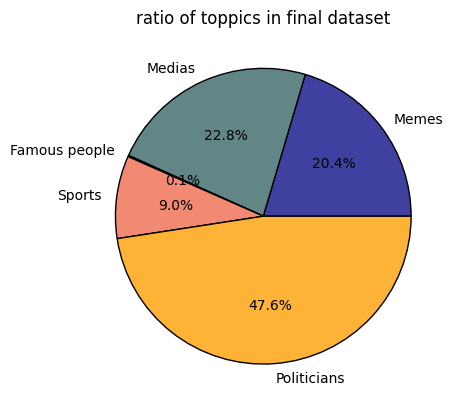

In [19]:
plt.pie(
    [meme_share, media_share, fame_share, sport_share, politics_share],
    labels=['Memes', 'Medias', 'Famous people', 'Sports', 'Politicians'],
    autopct='%1.1f%%',
    wedgeprops= {
        'edgecolor': 'BLACK'
    },
    colors=[BLUE, GREEN, AQUA, ORANGE, YELLOW]
)

plt.title('ratio of toppics in final dataset')
plt.show()

In [20]:
final_dataset = []

final_dataset += meme_samples_final
final_dataset += media_samples_final
final_dataset += famous_samples_final
final_dataset += sport_samples_final
final_dataset += politican_samples_final

final_post_num = post_fame + post_media + post_meme + post_sport + post_politics

In [21]:
print(f'Dataset has {len(final_dataset)} samples. {final_post_num} are posts out of it.')

Dataset has 171579 samples. 468 are posts out of it.


### Pie chart of post ratio in the dataset

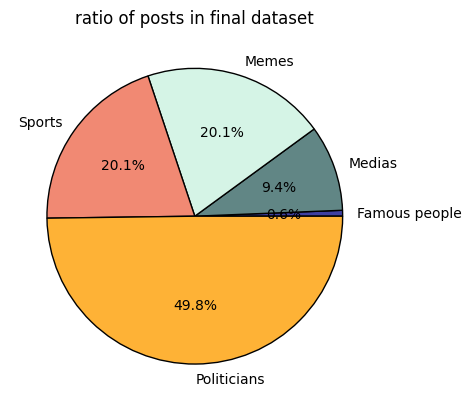

In [73]:
plt.pie(
    [post_fame, post_media, post_meme, post_sport, post_politics],
    labels=['Famous people', 'Medias', 'Memes', 'Sports', 'Politicians'],
    autopct='%1.1f%%',
    wedgeprops= {
        'edgecolor': 'BLACK'
    },
    colors=[BLUE, GREEN, AQUA, ORANGE, YELLOW]
)

plt.title('ratio of posts in final dataset')
plt.show()

# GDPR protection

In [23]:
GDPR_final = final_dataset.copy()

In [24]:
author_mapping = {}
idx = 1
for sample in final_dataset:
    author = sample['author'].lower()
    if author not in author_mapping:
        author_mapping[author] = f'user{idx}'
        idx += 1

In [25]:
keys_to_delete = []
for key in tqdm(author_mapping.keys()):
    if len(key) < 7:
        keys_to_delete.append(key)

100%|██████████| 47254/47254 [00:00<00:00, 2697741.07it/s]


In [26]:
for key in keys_to_delete:
    del author_mapping[key]

In [28]:
for sample in tqdm(final_dataset):
    author = sample['author'].lower()
    if author in author_mapping:
        sample['author'] = author_mapping[author]
    
    for key in author_mapping:
        sample['text'] = sample['text'].lower().replace(key, author_mapping[key])

100%|██████████| 171579/171579 [1:01:55<00:00, 46.18it/s]


In [39]:
with open('final.jsonl', 'w') as f:
    for item in final_dataset:
        json.dump(item, f)
        f.write('\n')

### ID appending

In [30]:
id = 1
for item in tqdm(final_dataset):
    item['id'] = id
    id += 1

100%|██████████| 171579/171579 [00:00<00:00, 2332284.88it/s]


In [31]:
with open('final_id_v2.jsonl', 'w') as f:
    for item in final_dataset:
        json.dump(item, f)
        f.write('\n')

## Sentiment data reducing

In [32]:
sentiment_pipe = pipeline("text-classification", model="kinit/slovakbert-sentiment-twitter")

In [46]:
positive_samples = []
negative_samples = []
neutral_samples = []

# Batch processing for efficiency
batch_size = 500
batched_texts = [final_dataset[i:i + batch_size] for i in range(0, len(final_dataset), batch_size)]

for batch in tqdm(batched_texts):
    try:
        sentiments = sentiment_pipe([sample['text'] for sample in batch])
        for sample, sentiment in zip(batch, sentiments):
            sentiment_val = sentiment['label']
            if sentiment_val == '1':
                positive_samples.append(sample)
                continue
            elif sentiment_val == '0':
                neutral_samples.append(sample)
                continue
            negative_samples.append(sample)
    except Exception as err:
        pass

100%|██████████| 344/344 [2:30:05<00:00, 26.18s/it]  


In [52]:
with open('classified_data/neutral_v1.jsonl', 'w') as f:
    for item in neutral_samples:
        json.dump(item, f)
        f.write('\n')

# Merging classified data

In [68]:
def load_jsonl(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return [json.loads(line) for line in file]

In [130]:
positive_samples = load_jsonl('classified_data/positive.jsonl')
negative_samples = load_jsonl('classified_data/negative.jsonl')
neutral_samples = load_jsonl('classified_data/neutral.jsonl')

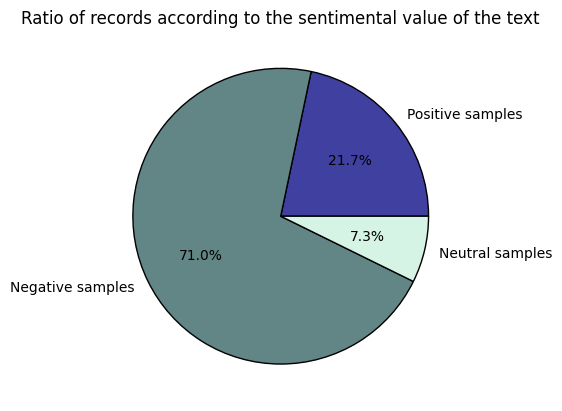

In [53]:
plt.pie(
    [len(positive_samples), len(negative_samples), len(neutral_samples)],
    labels=['Positive samples', 'Negative samples', 'Neutral samples'],
    autopct='%1.1f%%',
    wedgeprops= {
        'edgecolor': 'BLACK'
    },
    colors=[BLUE, GREEN, AQUA]
)

plt.title('Ratio of records according to the sentimental value of the text')
plt.show()

# Extracting samples with swear words

In [54]:
def find_word(words: list, sample: str):

    for word in words:
        if re.search(r'\b' + word + r'\b', sample.lower()) is not None:
            return True
    return False

In [55]:
swear_words = (
    'kokot',
    'kkt',
    'koko*',
    'pi.',
    'pi*'
    'pic',
    'pič',
    'sedl',
    'hovn',
    'retard',
    'bastard',
    'idiot',
    'kurv',
    'geň',
    'geno',
    'riť',
    'rit',
    'anal',
    'jeb',
    'curak',
    'čur',
    'chuj',
    'srack',
    'srač',
    'hoveda',
    'hovada',
    'hoväd',
    'cigan',
    'cigán',
    'neger',
    'negri',
    'blaznov',
    'bláznov',
    'blazon',
    'blázon',
    'krist',
    'hajz',
    'stet',
    'štet',
    'sex',
    'gay',
    'gej',
    'buzerant',
    'buzik',
    'tepl',
    'hanb',
    'hamb',
    'nigg',
    'uchyl',
    'uchil',
    'hnus',
    'potkan',
    'trapn',
    'odpad',
    'zmrd',
    'drog',
    'zlatok',
    'vymydl',
    'mrch',
    'fet',
    'zbabelec',
    'psycho',
    'k.k.t',
    'maria',
    'mariu',
    'svin',
    'egocent',
    'chuda',
    'bit',
    'nasilnik',
    'spodina',
    'spo.dina',
    'magor',
    'tyran',
    'tiran',
    'boha',
    'spina',
    'dement',
    'hnoj',
    'dobil',
    'psicho',
    'hajzl',
    'komediant',
    'nechutny',
    'sprostak',
    'mafia',
    'cecky',
    'ser',
    'vola',
    'klam',
    'cirkus',
    'huba',
    'huby',
    'trtko',
    'trtkat',
    'o.e'
)



In [56]:
neg_swear_samples = []
pos_swear_samples = []
neu_swear_samples = []

In [57]:
for sample in tqdm(negative_samples):
    if find_word(swear_words, sample['text']):
        neg_swear_samples.append(sample)

len(neg_swear_samples)

100%|██████████| 111568/111568 [00:18<00:00, 6070.15it/s]


3485

In [58]:
for sample in tqdm(positive_samples):
    if find_word(swear_words, sample['text']):
        pos_swear_samples.append(sample)

len(pos_swear_samples)

100%|██████████| 34083/34083 [00:04<00:00, 7840.59it/s]


182

In [59]:
for sample in tqdm(neutral_samples):
    if find_word(swear_words, sample['text']):
        neu_swear_samples.append(sample)

len(neu_swear_samples)

100%|██████████| 11428/11428 [00:00<00:00, 11980.43it/s]


79

In [60]:
def get_samples_without_swear_words(samples: list, swear_samples: list):
    return [item for item in samples if item not in swear_samples]

In [61]:
positive_without_swear = get_samples_without_swear_words(positive_samples, pos_swear_samples)
negative_without_swear = get_samples_without_swear_words(negative_samples, neg_swear_samples)

In [62]:
def get_random_samples_by_len(samples: list, length: int):
    random.shuffle(samples)
    return samples[:length]

# Computing sample percentage

In [63]:
len(neutral_samples) # 20 % of the data


11428

In [64]:
shuffled_positive_data = get_random_samples_by_len(positive_without_swear, len(neutral_samples) - len(pos_swear_samples)) # other 20% the same  as neutral data

In [65]:
shuffled_negative_data = get_random_samples_by_len(negative_without_swear, int((((2 * len(neutral_samples)) / 40) * 60)) - len(neg_swear_samples)) # next 60%

In [66]:
len(shuffled_negative_data) + len(neg_swear_samples)

34284

# Final dataset merge

In [67]:
classified_data = []

def append_final(input_list: list):
    for sample in input_list:
        classified_data.append(sample)


append_final(neutral_samples)
append_final(pos_swear_samples)
append_final(shuffled_positive_data)
append_final(neg_swear_samples)
append_final(shuffled_negative_data)

random.shuffle(classified_data)

id = 1
for sample in classified_data:
    sample['id'] = id
    id += 1

In [68]:
len(classified_data)

57140

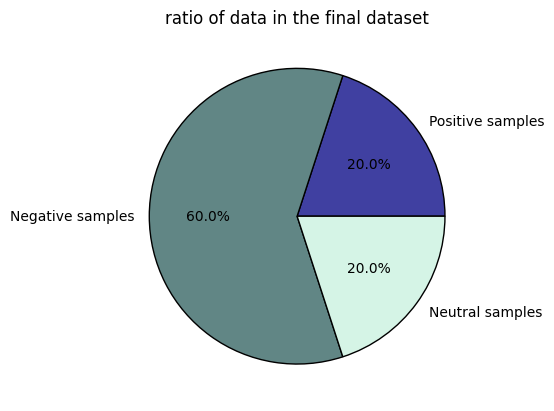

In [69]:
plt.pie(
    [len(shuffled_positive_data) + len(pos_swear_samples), len(shuffled_negative_data) + len(neg_swear_samples), len(neutral_samples)],
    labels=['Positive samples', 'Negative samples', 'Neutral samples'],
    autopct='%1.1f%%',
    wedgeprops= {
        'edgecolor': 'BLACK'
    },
    colors=[BLUE, GREEN, AQUA]
)

plt.title('ratio of data in the final dataset')
plt.show()

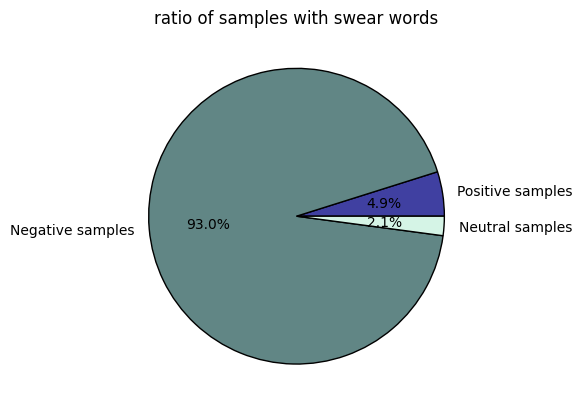

In [70]:
plt.pie(
    [len(pos_swear_samples), len(neg_swear_samples), len(neu_swear_samples)],
    labels=['Positive samples', 'Negative samples', 'Neutral samples'],
    autopct='%1.1f%%',
    wedgeprops= {
        'edgecolor': 'BLACK'
    },
    colors=[BLUE, GREEN, AQUA]
)

plt.title('ratio of samples with swear words')
plt.show()

In [71]:
with open('final_id_v2.jsonl', 'w') as f:
    for item in classified_data:
        json.dump(item, f)
        f.write('\n')